# Exercises for Spark 
by Viggo Gascou  viga@itu.dk & Thorvald Sørensen thso@itu.dk | 19-09-2023

## Connecting to the Spark Cluster job using the two JobParameters.json

To connect this jupyter notebook with your Spark cluster, we need to tell jupyter how it can access the spark cluster. Below code accomplishes that. 

In [ ]:
#####################################################################
# DO NOT CHANGE ANYTHING HERE.
# IF YOU HAVE PROBLEMS, CHECK THE ASSIGNMENT GUIDE CAREFULLY 
#####################################################################
    
# Only execute this cell once.
if 'EXECUTED' in globals():
    # check if variable 'EXECUTED' exists in the global variable namespace
    print("Already been executed once, not running again!")
else:
    print("Cell has not been executed before, running...")
    import os, json, pyspark
    from pyspark.conf import SparkConf
    from pyspark.sql import SparkSession, functions as F

    # Two files are automatically read: JobParameters.json for the Spark Cluster job using a temporary spark instance
    # and JobParameters.json for the Jupyter Lab job to extract the hostname of the cluster. 

    MASTER_HOST_NAME = None

    # Open the parameters Jupyter Lab app was launched with
    with open('/work/JobParameters.json', 'r') as file:
        JUPYTER_LAB_JOB_PARAMS = json.load(file)
        # from pprint import pprint; pprint(JUPYTER_LAB_JOB_PARAMS) 
        for resource in JUPYTER_LAB_JOB_PARAMS['request']['resources']:
            if 'hostname' in resource.keys():
                MASTER_HOST_NAME = resource['hostname']

    MASTER_HOST = f"spark://{MASTER_HOST_NAME}:7077"

    conf = SparkConf().setAll([
            ("spark.app.name", 'reading_job_params_app'), 
            ("spark.master", MASTER_HOST),
        ])
    spark = SparkSession.builder.config(conf=conf)\
                                .getOrCreate()

    CLUSTER_PARAMETERS_JSON_DF = spark.read.option("multiline","true").json('/work/JobParameters.json')

    # Extract cluster info from the specific JobParameters.json
    NODES = CLUSTER_PARAMETERS_JSON_DF.select("request.replicas").first()[0]
    CPUS_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.cpu").first()[0] - 1
    MEM_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.memoryInGigs").first()[0]

    CLUSTER_CORES_MAX = CPUS_PER_NODE * NODES
    CLUSTER_MEMORY_MAX = MEM_PER_NODE * NODES 

    EXECUTOR_CORES = CPUS_PER_NODE - 1  # set cores per executor on worker node
    EXECUTOR_MEMORY = int(
        MEM_PER_NODE / (CPUS_PER_NODE / EXECUTOR_CORES) * 0.5
    )  # set executor memory in GB on each worker node

    # Make sure there is a dir for spark logs
    if not os.path.exists('spark_logs'):
        os.mkdir('spark_logs')

    conf = SparkConf().setAll(
        [
            ("spark.app.name", 'spark_assignment'), # Change to your liking 
            ("spark.sql.caseSensitive", False), # Optional: Make queries strings sensitive to captialization
            ("spark.master", MASTER_HOST),
            ("spark.cores.max", CLUSTER_CORES_MAX),
            ("spark.executor.cores", EXECUTOR_CORES),
            ("spark.executor.memory", str(EXECUTOR_MEMORY) + "g"),
            ("spark.eventLog.enabled", True),
            ("spark.eventLog.dir", "spark_logs"),
            ("spark.history.fs.logDirectory", "spark_logs"),
            ("spark.deploy.mode", "cluster"),
        ]
    )

    ## check executor memory, taking into accout 10% of memory overhead (minimum 384 MiB)
    CHECK = (CLUSTER_CORES_MAX / EXECUTOR_CORES) * (
        EXECUTOR_MEMORY + max(EXECUTOR_MEMORY * 0.10, 0.403)
    )

    assert (
        int(CHECK) <= CLUSTER_MEMORY_MAX
    ), "Executor memory larger than cluster total memory!"

    # Stop previous session that was just for loading cluster params
    spark.stop()

    # Start new session with above config, that has better resource handling
    spark = SparkSession.builder.config(conf=conf)\
                                .getOrCreate()
    sc = spark.sparkContext
    EXECUTED = True
    print("Success!")


## Transforming data using SQL, DataFrames and RDDs (Resillient Distributed Datasets)
Today's exercise will let you dig deeper into how a Spark Cluster operates. So far you have worked with a high-level API, that is, a simplification of a more complex API. You have tried to transform data using DataFrames and perhaps SQL like syntax. Today you will try to use RDDs.

DataFrame operations are built on top of RDDs and compile down to these lower level tools for convenient and extremely efficient distributed execution. There are some things that you might use RDDs for, especially when you’re reading or manipulating raw data, but for the assignment, you should stick to the Structured APIs.

<img src=attachment:911c73e3-29a1-4d35-9ad1-3e0d5249a113.png width="500">

## Loading the data
Here we specify where the textfile is located on UCloud and read it using the spark session. 

In [ ]:
reviews = spark.read.json('file:////work/yelp/yelp_academic_dataset_review.json').select("text").rdd

Let's see the data type this object. How does it differ to what you have used for your assignement?

In [ ]:
type(reviews)

If you want to use e.g., the first 5000 reviews you can use the limit function as such

In [ ]:
reviews_subset = spark.read.json('file:////work/yelp/yelp_academic_dataset_review.json').select("text").limit(5000).rdd

In [ ]:
reviews_subset.take(2)

# Part A): Counting the occurences of every word in the reviews column  
For this first part, you will try to use the above RDD and code a solution (using the RDD API instead of the DataFrame API that you have been used to)

**Remember to take a look at the PySpark docs on the different functions that are available on RDD's (Resilient Distributed Dataset's) [here](https://spark.apache.org/docs/3.3.1/api/python/reference/pyspark.html#rdd-apis)**

In particular these functions are useful for this exercise:
* [flatMap](https://spark.apache.org/docs/3.3.1/api/python/reference/api/pyspark.RDD.flatMap.html)
* [map](https://spark.apache.org/docs/3.3.1/api/python/reference/api/pyspark.RDD.map.html)
* [reduceByKey](https://spark.apache.org/docs/3.3.1/api/python/reference/api/pyspark.RDD.reduceByKey.html)
* [sortBy](https://spark.apache.org/docs/3.3.1/api/python/reference/api/pyspark.RDD.sortBy.html)

Map applies a function to every element, and outputs the same number of elements. Flatmap applies a function, but returns several elements per original element.

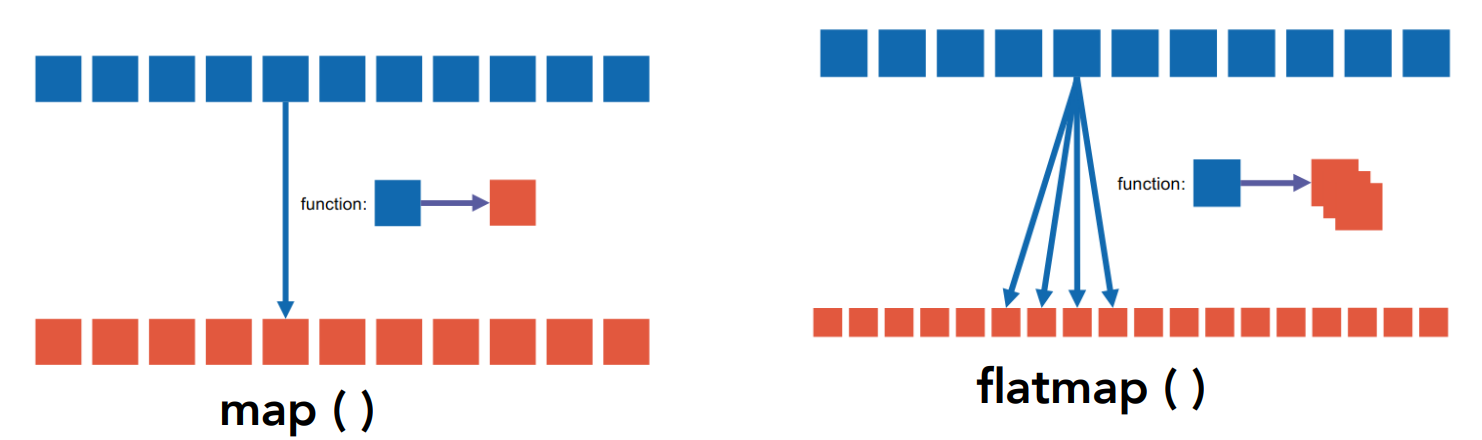

Also remember that you can use the [take()](https://spark.apache.org/docs/3.3.1/api/python/reference/api/pyspark.RDD.take.html) function to take a look at the first `N` elements of an RDD.

Finally take a look at the Python docs to see how you can manipulate strings in Python as well as how to create lambda functions:
* [String manipulation in Python](https://docs.python.org/3/library/stdtypes.html#string-methods)
* [Lambda functions in Python](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions)

For example a flatMap function that swaps the case of the letters in a string `x` could look like this:
```python
rdd = rdd.flatMap(lambda x: x.text.swapcase())
rdd.take(1)
```

Notice that above example access the `.text`  object in order to be able to use python's string manipulation functions.

## Tokenizing the words
First we need to tokenize each word on all the lines in the text file (split each line into words). Then we need to flatten that into a single RDD with just the words.

In [ ]:
# Your code here...

## Count the words
Next for each word we need to create a key-value pair with the word as the key and 1 as the value.

In [ ]:
# Your code here...

## Summing the counts
Now we need to aggregate the counts such that for each word we get a single key-value pair. Where the key is the word and the value is the number of occurences of that word.

In [ ]:
# Your code here...

## Sorting the counts
Finally we can sort the results either by the number of occurences (the value) or alphabetically (the key)

#### By value (numerically)

In [ ]:
# Your code here...

### By key (alphabetically)

In [ ]:
# Your code here...

# Part b) Understanding the workings of the Spark cluster

For this exercise, you will need the SparkMonitor tab located at the top in JupyterLab. Use port 4040 and reload the page often using the "Reload" button at the top left. You will also need to go to the UCloud page for your spark cluster, and open the interface for one of your nodes. 

Helpful and recommended reading are found at the bottom of the assignment pdf. Furthermore the `A-Gentle-Introduction-to-Apache-Spark.pdf` is useful find it under todays lecture on LearnIT (page 11-30). Note that some questions require you to read on the spark documentation.

**Question 1)**

How many nodes (workers) does your cluster have?

**Question 2)**  

What is the relationship between a spark application, driver process and a spark session? What is the name of the variable for your spark session?

**Question 3)**

What is the difference between a Spark Job, stage and task?

**Question 3a)**

Try to execute a cell that takes a while to complete, such as sorting the counts from part A). Explore the SparkMonitor web UI click around and find the pages for the Stages. See if you can find the DAG Visualization and briefly explain how spark computes the answer of your word count (conceptually, in simple terms). 

**Question 3b)**

Again, try to execute a cell that takes a while to complete, such as sorting the counts from part A). Open the interface for node 1 under the UCloud SparkCluster job. Explore the different pages and find the same spark web UI as you can see in JupyterLab.

**Question 4)** (Optional)

What type of scheduling mode does your cluster use? What does the abbriviation mean? What is the impact of the scheduling mode for a cluster used by several users? (compared to just you using the cluster).

**Question 5)** (Optional)

What is lazy evaluation and how does it affect the time it takes to run your code cells?